In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data preprocessing
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import cv2
#Model
import keras
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.layers.normalization import BatchNormalization
from keras.layers.normalization import batch_normalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.metrics import PrecisionAtRecall,Recall 
#Model Analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from numpy.random import seed
seed(0)
import tensorflow
tensorflow.random.set_seed(0)

In [3]:
!unzip /content/drive/MyDrive/COVID-19_Radiography_Database1.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6723.png  
  inflating:

In [4]:
path = '/content/COVID-19_Radiography_Dataset' #/content/COVID-19_Radiography_Dataset

diag_code_dict = {
    'COVID': 0,
    'Lung_Opacity': 1,
    'Normal': 2,
    'Viral Pneumonia': 3}

diag_title_dict = {
    'COVID': 'Covid-19',
    'Lung_Opacity': 'Lung Opacity',
    'Normal': 'Healthy',
    'Viral Pneumonia': 'Viral Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

covidData = pd.DataFrame.from_dict(imageid_path_dict, orient = 'index').reset_index()
covidData.columns = ['image_id','path']
classes = covidData.image_id.str.split('-').str[0]
covidData['diag'] = classes
covidData['target'] = covidData['diag'].map(diag_code_dict.get) 
covidData['Class'] = covidData['diag'].map(diag_title_dict.get) 

In [5]:
samples,features = covidData.shape
duplicated = covidData.duplicated().sum()
null_values = covidData.isnull().sum().sum()

print('Basic EDA')
print('Number of samples: %d'%(samples))
print('Number of duplicated values: %d'%(duplicated))
print('Number of Null samples: %d' % (null_values))

Basic EDA
Number of samples: 21165
Number of duplicated values: 0
Number of Null samples: 0


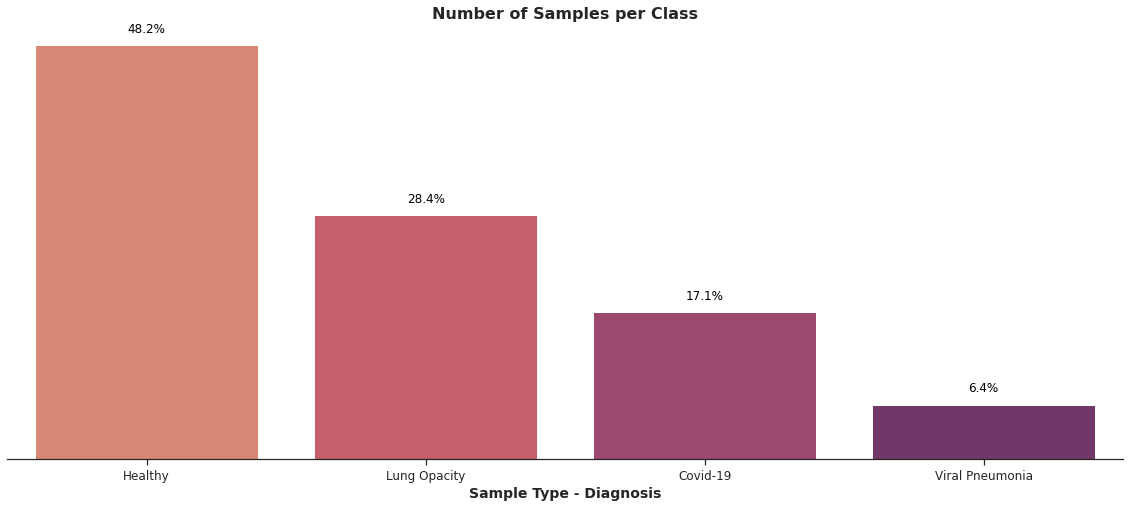

In [6]:
#Samples per class
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = covidData,x='Class',order = covidData['Class'].value_counts().index,palette="flare")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Sample Type - Diagnosis',fontsize = 14,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title('Number of Samples per Class', fontsize = 16,weight = 'bold');
#Plot numbers
for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/samples)), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
    ha='center', va='bottom', color='black', xytext=(0, 10),rotation = 'horizontal',
    textcoords='offset points')

In [7]:
covidData['image'] = covidData['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

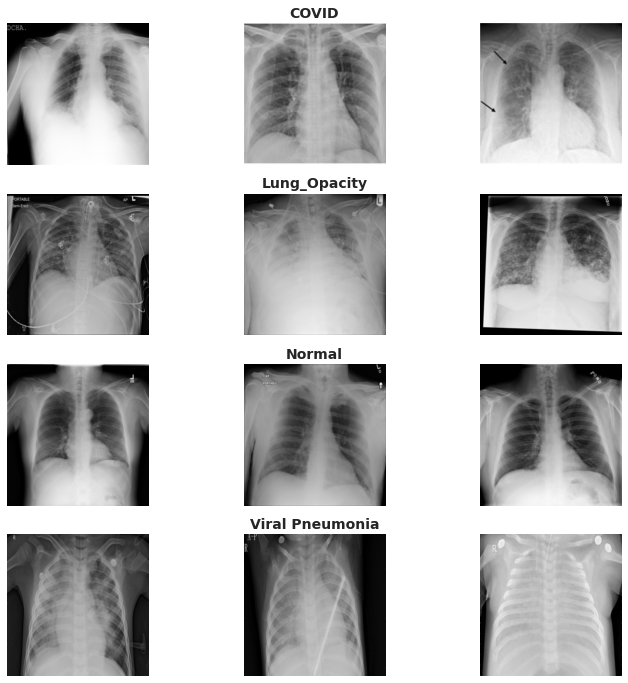

In [8]:
#Image Sampling
n_samples = 3

fig, m_axs = plt.subplots(4, n_samples, figsize = (4*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs,covidData.sort_values(['diag']).groupby('diag')):
    n_axs[1].set_title(type_name,fontsize = 14,weight = 'bold')
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

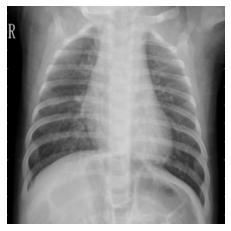

In [9]:
plt.figure()
pic_id = random.randrange(0, samples)
picture = covidData['path'][pic_id]
image = cv2.imread(picture)
plt.imshow(image)
plt.axis('off');
plt.show()    

In [10]:
print('Shape of the image : {}'.format(image.shape))
print('Image Hight {}'.format(image.shape[0]))
print('Image Width {}'.format(image.shape[1]))
print('Dimension of Image {}'.format(image.ndim))
print('Image size {}'.format(image.size))
print('Image Data Type {}'.format(image.dtype))
print('Maximum RGB value in this image {}'.format(image.max()))
print('Minimum RGB value in this image {}'.format(image.min()))

Shape of the image : (299, 299, 3)
Image Hight 299
Image Width 299
Dimension of Image 3
Image size 268203
Image Data Type uint8
Maximum RGB value in this image 228
Minimum RGB value in this image 0


In [11]:
image[0,0]

array([3, 3, 3], dtype=uint8)

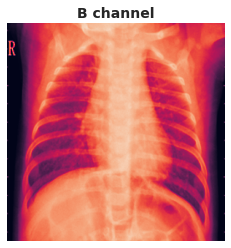

In [12]:
plt.title('B channel',fontsize = 14,weight = 'bold')
plt.imshow(image[ : , : , 0])
plt.axis('off');
plt.show()

In [13]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0,samples):
    mean_val.append(covidData['image'][i].mean())
    std_dev_val.append(np.std(covidData['image'][i]))
    max_val.append(covidData['image'][i].max())
    min_val.append(covidData['image'][i].min())

imageEDA = covidData.loc[:,['image', 'Class','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

subt_mean_samples = imageEDA['mean'].mean() - imageEDA['mean']
imageEDA['subt_mean'] = subt_mean_samples

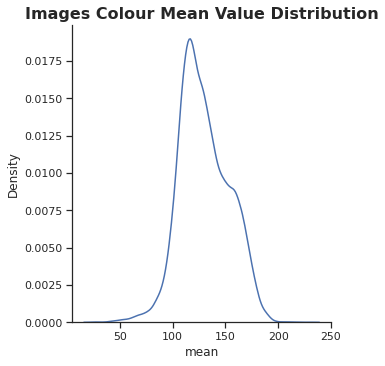

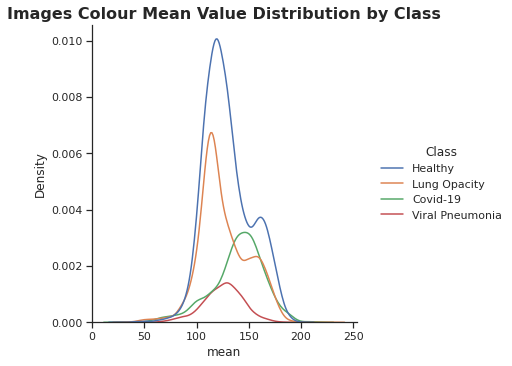

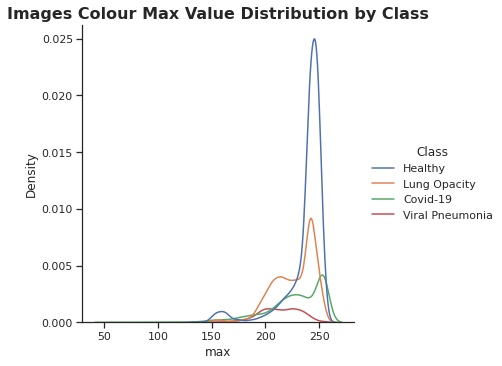

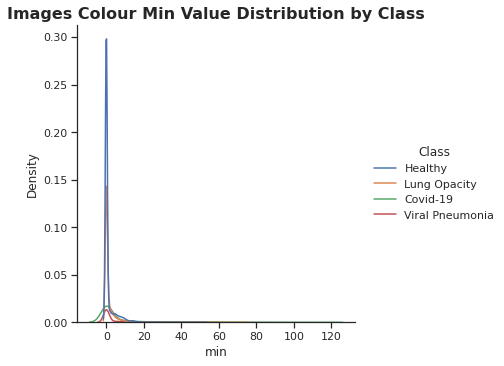

In [14]:
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde");
plt.title('Images Colour Mean Value Distribution', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'Class');
plt.title('Images Colour Mean Value Distribution by Class', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'Class');
plt.title('Images Colour Max Value Distribution by Class', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'Class');
plt.title('Images Colour Min Value Distribution by Class', fontsize = 16,weight = 'bold');

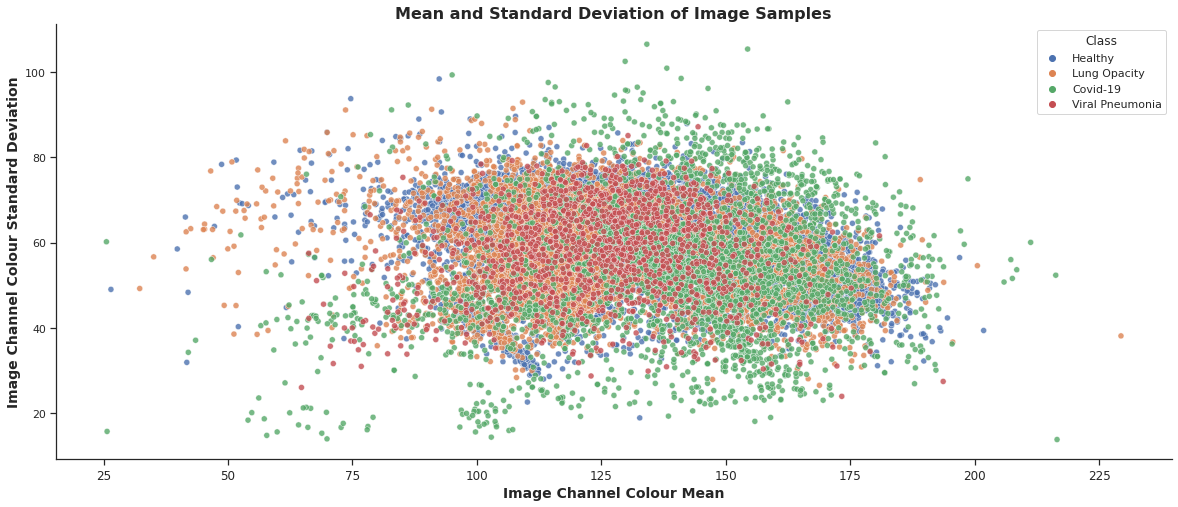

In [15]:
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=imageEDA, x="mean", y=imageEDA['stedev'], hue = 'Class',alpha=0.8);
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16,weight = 'bold');

<Figure size 1440x576 with 0 Axes>

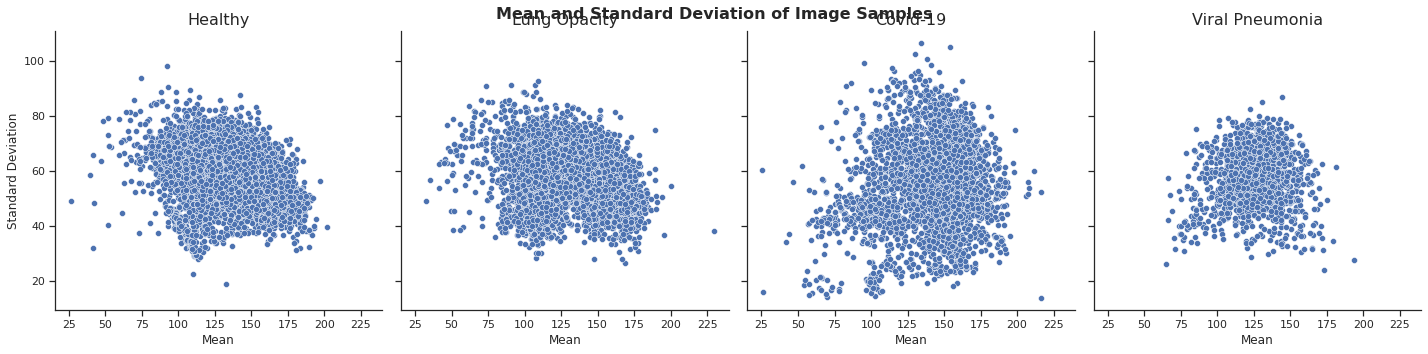

In [16]:
plt.figure(figsize=(20,8));
g = sns.FacetGrid(imageEDA, col="Class",height=5);
g.map_dataframe(sns.scatterplot, x='mean', y='stedev');
g.set_titles(col_template="{col_name}", row_template="{row_name}", size = 16)
g.fig.subplots_adjust(top=.7)
g.fig.suptitle('Mean and Standard Deviation of Image Samples',fontsize=16, weight = 'bold')
axes = g.axes.flatten()
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('Mean')
g.fig.tight_layout()

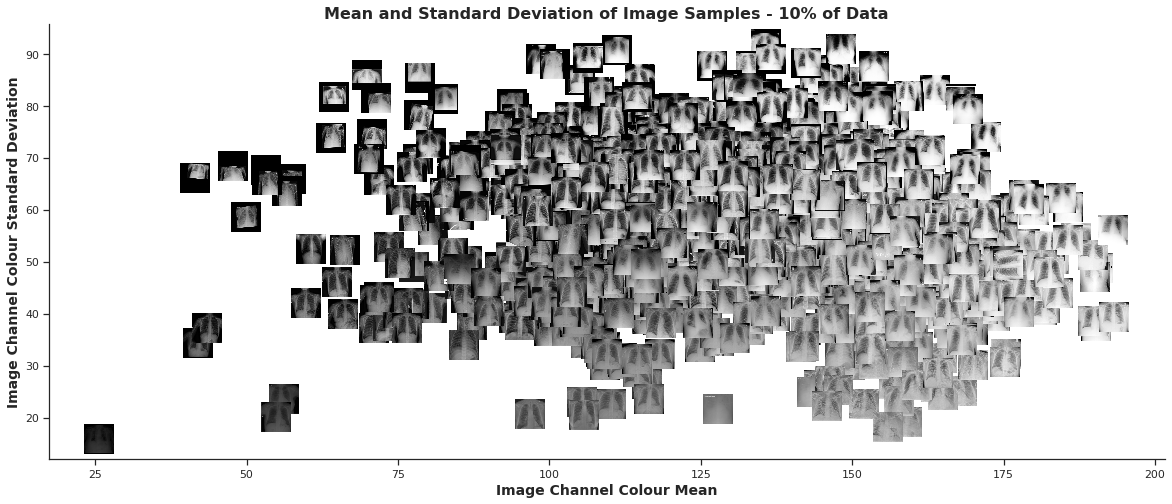

In [17]:
def getImage(path):
    return OffsetImage(cv2.imread(path),zoom = 0.1)

DF_sample = imageEDA.sample(frac=0.1, replace=False, random_state=1)
paths = DF_sample['path']

fig, ax = plt.subplots(figsize=(20,8))
ab = sns.scatterplot(data=DF_sample, x="mean", y='stedev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Mean and Standard Deviation of Image Samples - 10% of Data', fontsize = 16,weight = 'bold');

for x0, y0, path in zip(DF_sample['mean'], DF_sample['stedev'],paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

In [18]:
#add the path general where the classes subpath are allocated
path = '/content/COVID-19_Radiography_Dataset'

classes=["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
num_classes = len(classes)
batch_size = 16

#Define the parameters to create the training and validation set Images and Data Augmentation parameters
train_datagen = ImageDataGenerator(rescale=1./255,
                                   #rotation_range=20,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   #horizontal_flip=True,
                                   validation_split=0.2)

#**No Augmentation on the Test set Images**
test_datagen = ImageDataGenerator(rescale=1./255, 
                                  validation_split=0.2)


#loading the images to training set
train_gen = train_datagen.flow_from_directory(directory=path, 
                                              target_size=(224, 224),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="rgb")
#loading the images to test set
test_gen = test_datagen.flow_from_directory(directory=path, 
                                              target_size=(224, 224),
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="rgb")

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [19]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [20]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [21]:
# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss


In [22]:
!pip install efficientnet
import efficientnet.tfkeras as efn

     |████████████████████████████████| 50 kB 4.1 MB/s 


In [23]:
# dfault input shapes 
import tensorflow as tf
print(tf.keras.applications.DenseNet201(weights='imagenet').input_shape)
print(efn.EfficientNetB7(weights='imagenet').input_shape) # make this to B0 
print(tf.keras.applications.VGG16(weights='imagenet').input_shape)
print(tf.keras.applications.NASNetLarge(weights='imagenet').input_shape)

82534400/82524592 [==============================] - 1s 0us/step
(None, 224, 224, 3)
268328960/268317848 [==============================] - 4s 0us/step
(None, 600, 600, 3)
553476096/553467096 [==============================] - 4s 0us/step
(None, 224, 224, 3)
359759872/359748576 [==============================] - 3s 0us/step
(None, 331, 331, 3)


In [24]:
pretrained_MobileNet = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in pretrained_MobileNet.layers:
  layer.trainable = False

x1 = pretrained_MobileNet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head_MbNet")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head_MbNet")(x1)
x1 = tf.keras.layers.Dense(128, activation="relu", name="dense_head_MbNet")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head_MbNet")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head_2_MbNet")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head_2_MbNet")(x1)
model_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions_head_MbNet")(x1)

model_MobileNet = Model(inputs=pretrained_MobileNet.input, outputs=model_out)
#model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=categorical_smooth_loss,metrics=['accuracy'])
#model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=[Recall()])
#Compile the model


opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model_MobileNet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#model_MobileNet.summary()

17235968/17225924 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [25]:
#Model Parameters
epochs = 3 # make it 1000

#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100,monitor='val_loss', mode = 'min',verbose=0)

callbacks_list = [learning_rate_reduction,early_stopping_monitor]

#Verbose set to 0 to avoid Notebook visual pollution
history = model_MobileNet.fit(train_gen, steps_per_epoch=len(train_gen) // batch_size, 
                                validation_steps=len(test_gen) // batch_size, 
                                validation_data=test_gen, epochs=epochs,callbacks=[callbacks_list],
                                verbose=1)
#Predict Results on test set
y_pred = model_MobileNet.predict(test_gen)

Epoch 1/3
66/66 [==============================] - 50s 721ms/step - loss: 4.0660 - accuracy: 0.4735 - val_loss: 1.4089 - val_accuracy: 0.3008
Epoch 2/3
66/66 [==============================] - 47s 717ms/step - loss: 1.1694 - accuracy: 0.5530 - val_loss: 1.5091 - val_accuracy: 0.0000e+00
Epoch 3/3
66/66 [==============================] - 48s 732ms/step - loss: 1.0426 - accuracy: 0.6070 - val_loss: 1.5759 - val_accuracy: 0.0000e+00


In [26]:
last_conv_layer_name = "conv5_block32_concatination"
classifier_layer_names = [
    "bn",
    "relu",
    "averagepooling2d_head_MbNet",
    "flatten_head_MbNet",
    "dense_head_MbNet",
    "dropout_head_MbNet",
    "dense_head_2_MbNet",
    "dropout_head_2_MbNet",
    "predictions_head_MbNet"
]

In [ ]:
model_DenseNet.save("model_MobileNet_30_09596.h5")

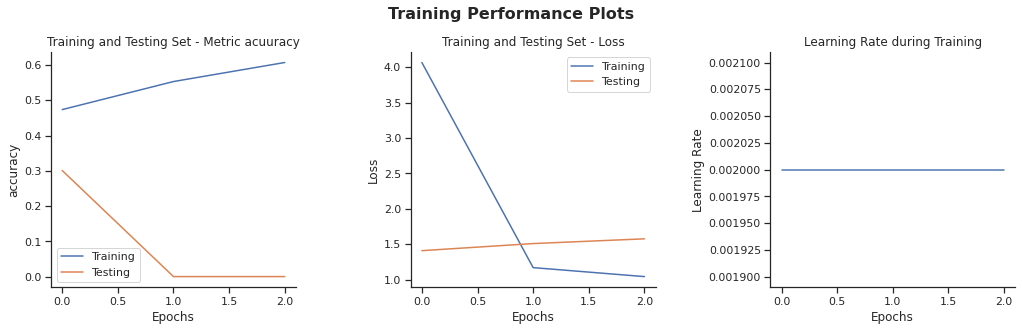

In [27]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="Testing");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="Testing");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Testing Set - Metric acuuracy")
axarr[1].set_title("Training and Testing Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

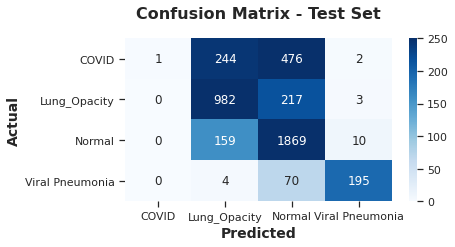

In [28]:
#transform the predictions into array such as [0,0,1,2...]
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
#Retrieve the True classes of the test set
y_true=test_gen.classes
#Build Confusion Matrix
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(6, 3))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

keras.backend.clear_session()

**Overall Results**
Accuracy Result: 72.00%
Precision Result: 83.64%
Recall Result: 61.51%
F-Score Result: 59.38%


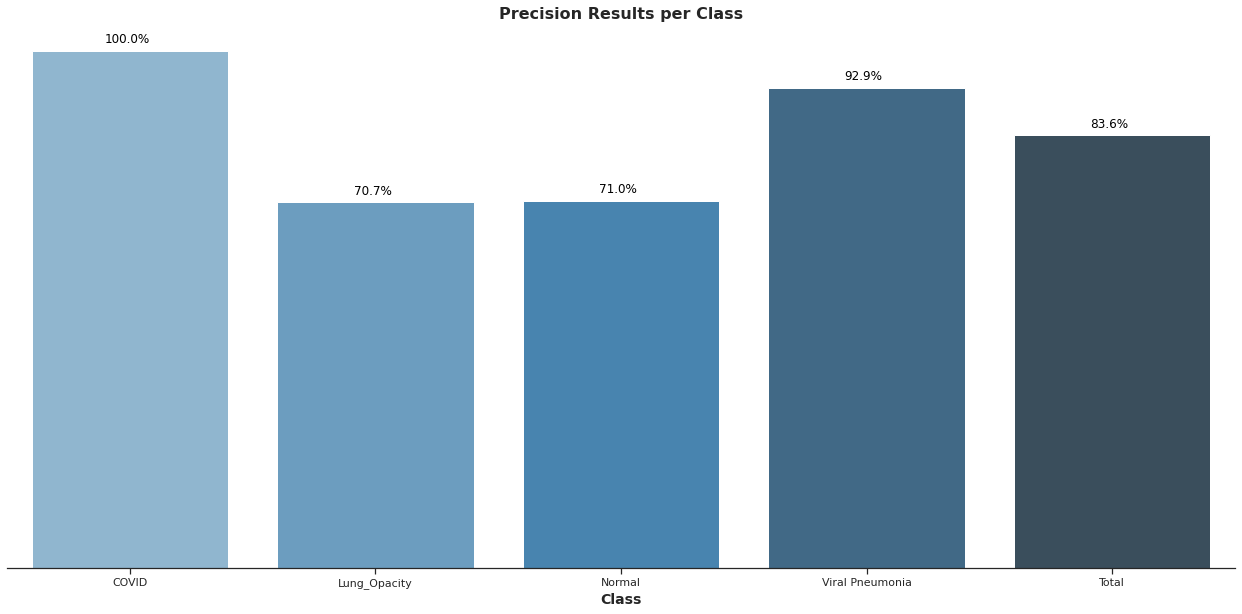

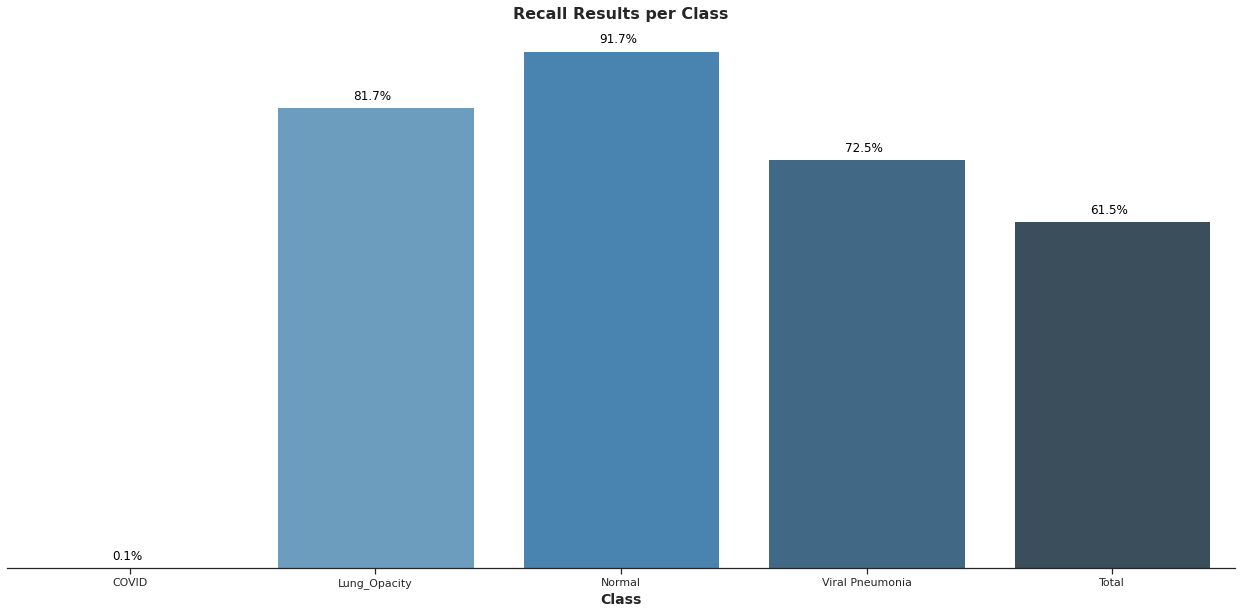

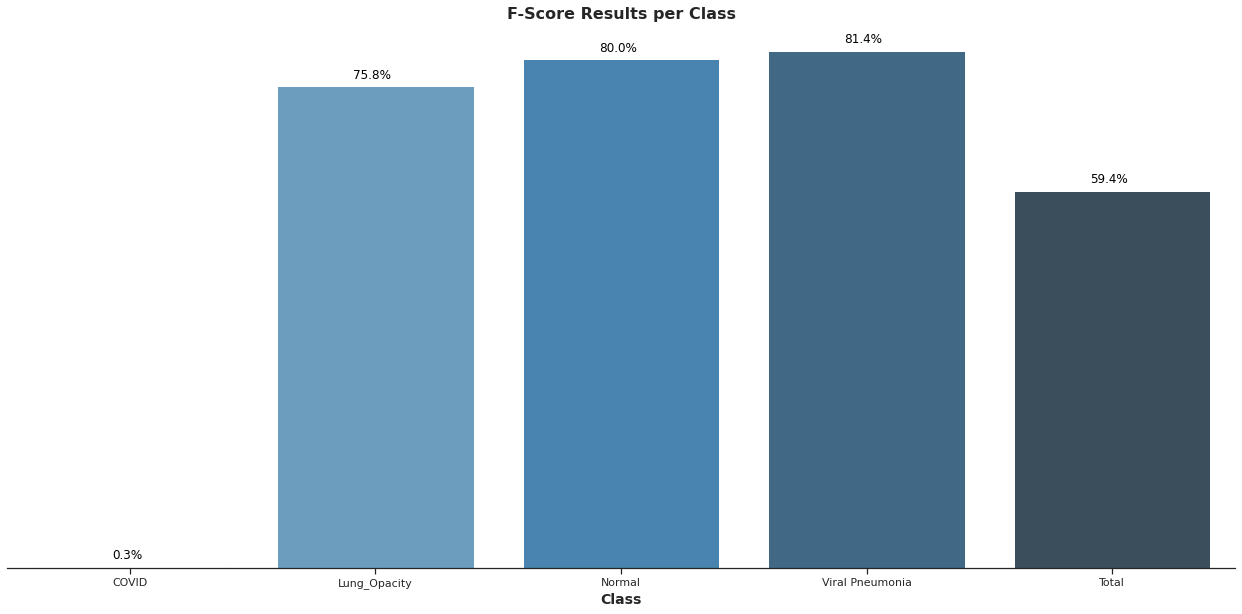

In [29]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[4,2]*100))#F-Score of the whole Dataset

In [30]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [31]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [32]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [33]:
# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [34]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_delta=0.001, patience=5, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=1)

In [35]:
# dfault input shapes 

print(tf.keras.applications.DenseNet201(weights='imagenet').input_shape)
print(efn.EfficientNetB7(weights='imagenet').input_shape) 
print(tf.keras.applications.VGG16(weights='imagenet').input_shape)

(None, 224, 224, 3)
(None, 600, 600, 3)
(None, 224, 224, 3)


In [36]:
pretrained_DenseNet = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in pretrained_DenseNet.layers:
  layer.trainable = False

x2 = pretrained_DenseNet.output
x2 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head_DenseNet")(x2)
x2 = tf.keras.layers.Flatten(name="flatten_head_DenseNet")(x2)
x2 = tf.keras.layers.Dense(128, activation="relu", name="dense_head_DenseNet")(x2)
x2 = tf.keras.layers.Dropout(0.5, name="dropout_head_DenseNet")(x2)
x2 = tf.keras.layers.Dense(64, activation="relu", name="dense_head_2_DenseNet")(x2)
x2 = tf.keras.layers.Dropout(0.5, name="dropout_head_2")(x2)
model_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions_head_DenseNet")(x2)

model_DenseNet = Model(inputs=pretrained_DenseNet.input, outputs=model_out)
#model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=categorical_smooth_loss,metrics=['accuracy'])
#model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=[Recall()])
#Compile the model


opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model_DenseNet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model_DenseNet.summary()

74850304/74836368 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [37]:
#Model Parameters
epochs = 3 # make it 1000

#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100,monitor='val_loss', mode = 'min',verbose=0)

callbacks_list = [learning_rate_reduction,early_stopping_monitor]

#Verbose set to 0 to avoid Notebook visual pollution
history = model_DenseNet.fit(train_gen, steps_per_epoch=len(train_gen) // batch_size, 
                                validation_steps=len(test_gen) // batch_size, 
                                validation_data=test_gen, epochs=epochs,callbacks=[callbacks_list],
                                verbose=1)
#Predict Results on test set
y_pred = model_DenseNet.predict(test_gen)

Epoch 1/3
66/66 [==============================] - 309s 5s/step - loss: 2.4106 - accuracy: 0.4413 - val_loss: 1.9861 - val_accuracy: 0.0156
Epoch 2/3
66/66 [==============================] - 298s 5s/step - loss: 1.0808 - accuracy: 0.5511 - val_loss: 1.7084 - val_accuracy: 0.0234
Epoch 3/3
66/66 [==============================] - 289s 4s/step - loss: 1.0994 - accuracy: 0.5521 - val_loss: 1.6878 - val_accuracy: 0.0000e+00


In [38]:
last_conv_layer_name = "conv5_block32_concat"
classifier_layer_names = [
    "bn",
    "relu",
    "averagepooling2d_head_DenseNet",
    "flatten_head_DenseNet",
    "dense_head_DenseNet",
    "dropout_head_DenseNet",
    "dense_head_2_DenseNet",
    "dropout_head_2_DenseNet",
    "predictions_head_DenseNet"
] 

In [39]:
model_DenseNet.save("model_densenet_30_09596.h5")

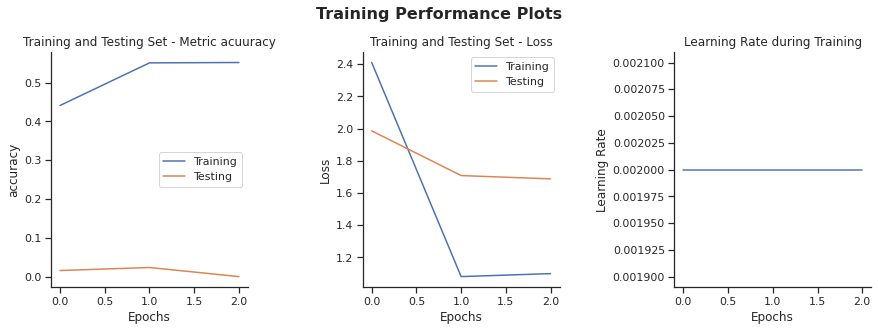

In [40]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(13,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="Testing");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="Testing");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Testing Set - Metric acuuracy")
axarr[1].set_title("Training and Testing Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

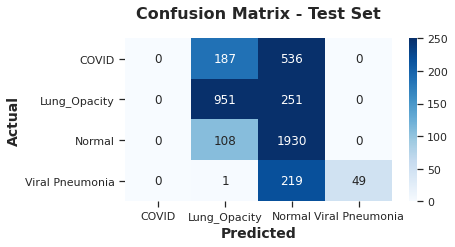

In [41]:
#transform the predictions into array such as [0,0,1,2...]
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
#Retrieve the True classes of the test set
y_true=test_gen.classes
#Build Confusion Matrix
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(6, 3))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

keras.backend.clear_session()

**Overall Results**
Accuracy Result: 69.23%
Precision Result: 85.50%
Recall Result: 48.01%
F-Score Result: 46.52%


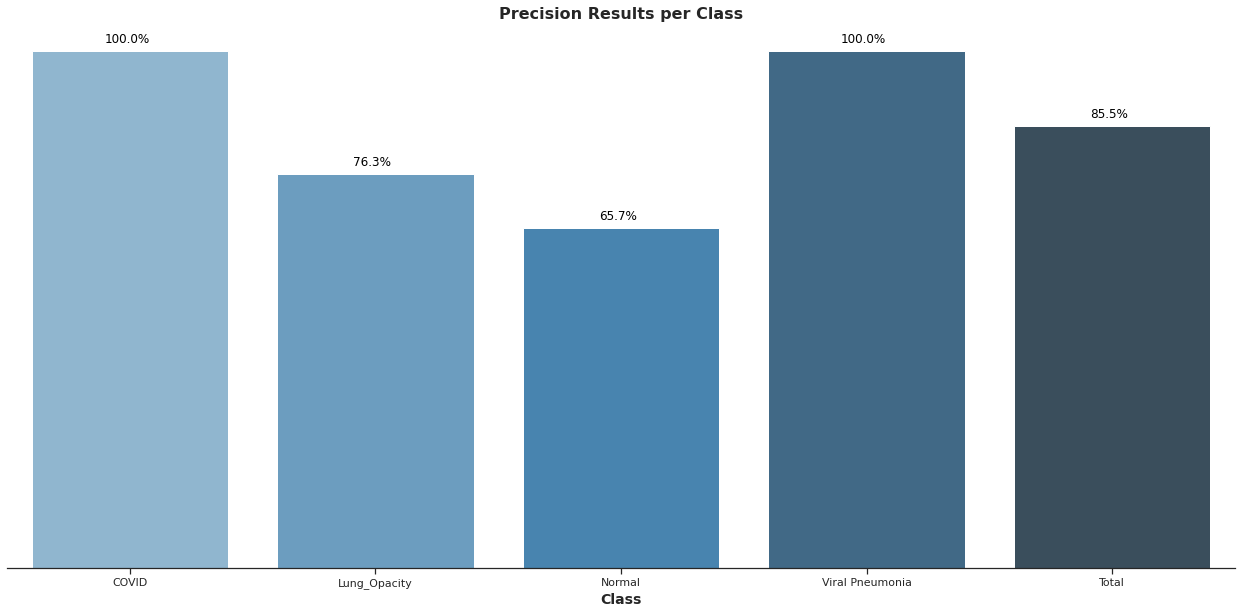

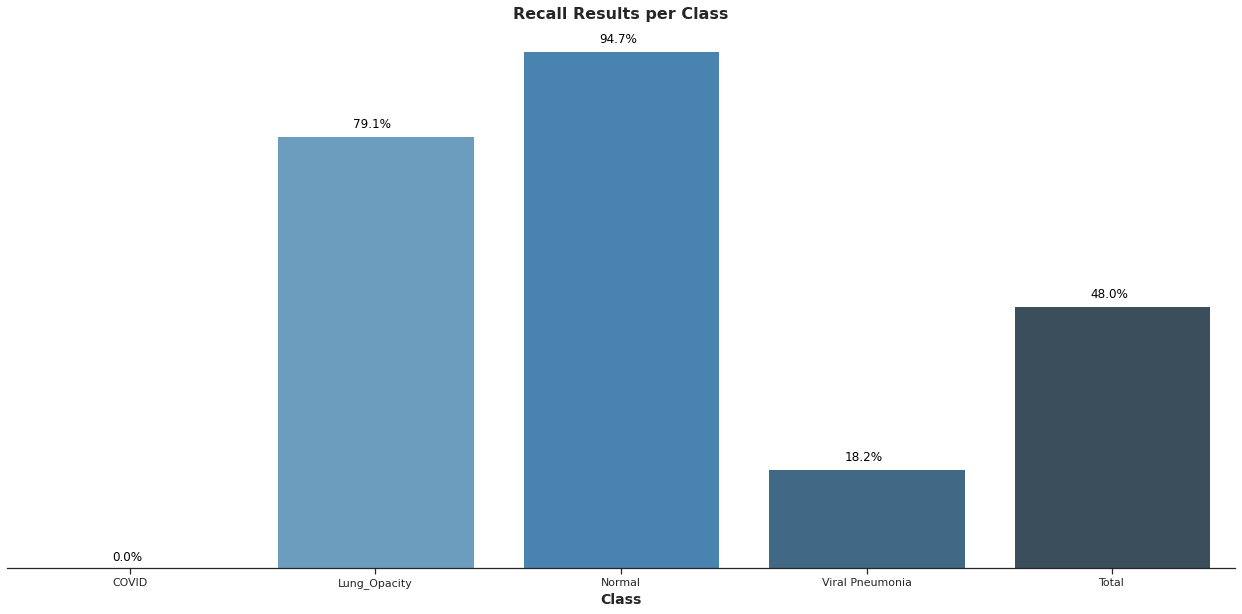

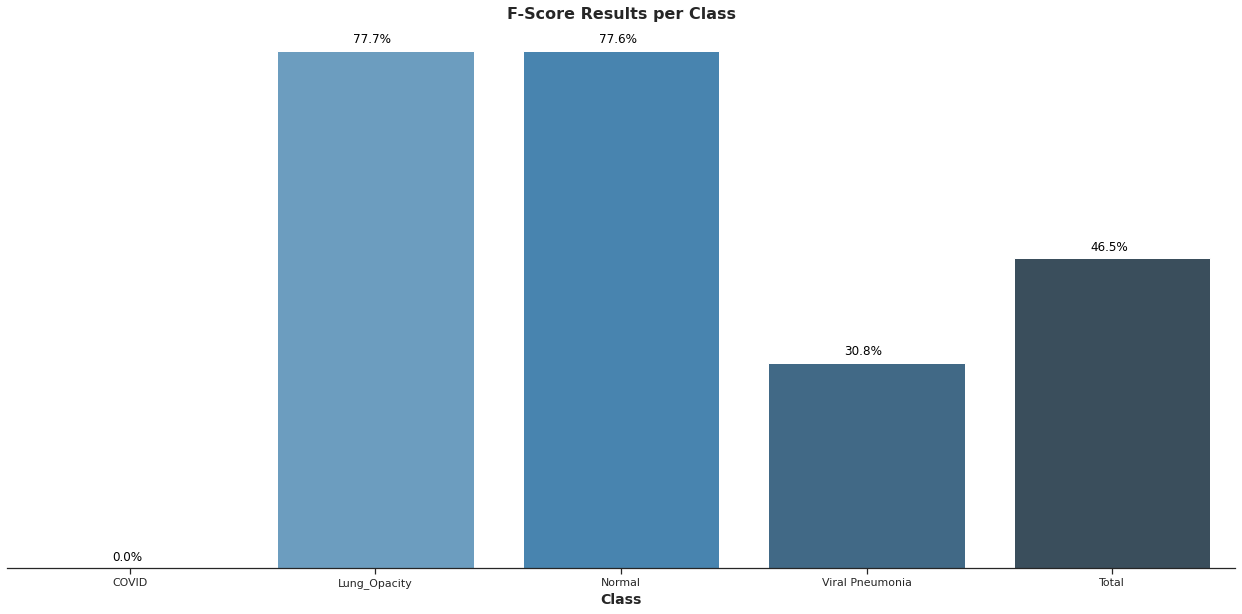

In [42]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[4,2]*100))#F-Score of the whole Dataset

In [43]:
pretrained_EfNet = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in pretrained_EfNet.layers:
  layer.trainable = False

x3 = pretrained_EfNet.output
x3 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head_EfNet")(x3)
x3 = tf.keras.layers.Flatten(name="flatten_head_EfNet")(x3)
#x3 = tf.keras.layers.Dense(256, activation="relu", name="dense_head")(x2)
#x3 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x2)
x3 = tf.keras.layers.Dense(128, activation="relu", name="dense_head_EfNet")(x3)
x3 = tf.keras.layers.Dropout(0.5, name="dropout_head_EfNet")(x3)
x3 = tf.keras.layers.Dense(64, activation="relu", name="dense_head_2_EfNet")(x3)
x3 = tf.keras.layers.Dropout(0.5, name="dropout_head_2_EfNet")(x3)
model_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions_head_EfNet")(x3)

model_EfNet = Model(inputs=pretrained_EfNet.input, outputs=model_out)
#model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=categorical_smooth_loss,metrics=['accuracy'])
#model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=[Recall()])
#Compile the model


opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model_EfNet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#model_efnet.summary()

16719872/16705208 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [44]:
#Model Parameters
epochs = 3 # make it 1000

#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100,monitor='val_loss', mode = 'min',verbose=0)

callbacks_list = [learning_rate_reduction,early_stopping_monitor]

#Verbose set to 0 to avoid Notebook visual pollution
history = model_EfNet.fit(train_gen, steps_per_epoch=len(train_gen) // batch_size, 
                                validation_steps=len(test_gen) // batch_size, 
                                validation_data=test_gen, epochs=epochs,callbacks=[callbacks_list],
                                verbose=1)
#Predict Results on test set
y_pred = model_EfNet.predict(test_gen)

Epoch 1/3
66/66 [==============================] - 78s 1s/step - loss: 1.6564 - accuracy: 0.4025 - val_loss: 1.5268 - val_accuracy: 0.0000e+00
Epoch 2/3
66/66 [==============================] - 69s 1s/step - loss: 1.2771 - accuracy: 0.4612 - val_loss: 1.5168 - val_accuracy: 0.0000e+00
Epoch 3/3
66/66 [==============================] - 70s 1s/step - loss: 1.2696 - accuracy: 0.4688 - val_loss: 1.4998 - val_accuracy: 0.0000e+00


In [45]:
last_conv_layer_name = "top_conv"
classifier_layer_names = [
    "top_bn",
    "top_activation",
    "averagepooling2d_head_EfNet",
    "flatten_head_EfNet",
    "dense_head_EfNet",
    "dropout_head_EfNet",
    "dense_head_2_EfNet",
    "dropout_head_2_EfNet",
    "predictions_head_EfNet"
]

In [46]:
model_EfNet.save("model_EfNet_30_09596.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


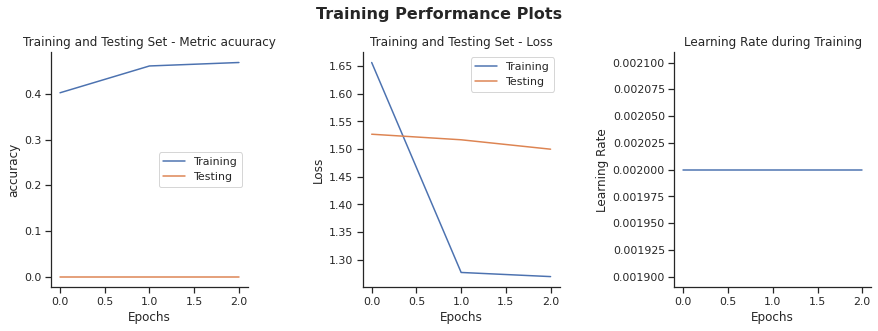

In [47]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(13,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="Testing");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="Testing");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Testing Set - Metric acuuracy")
axarr[1].set_title("Training and Testing Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

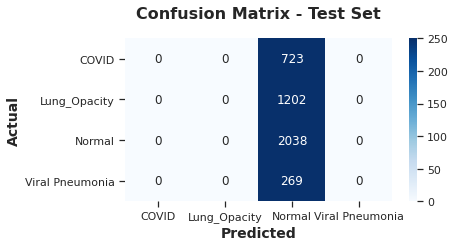

In [48]:
#transform the predictions into array such as [0,0,1,2...]
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
#Retrieve the True classes of the test set
y_true=test_gen.classes
#Build Confusion Matrix
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(6, 3))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

keras.backend.clear_session()

**Overall Results**
Accuracy Result: 48.16%
Precision Result: 87.04%
Recall Result: 25.00%
F-Score Result: 16.25%


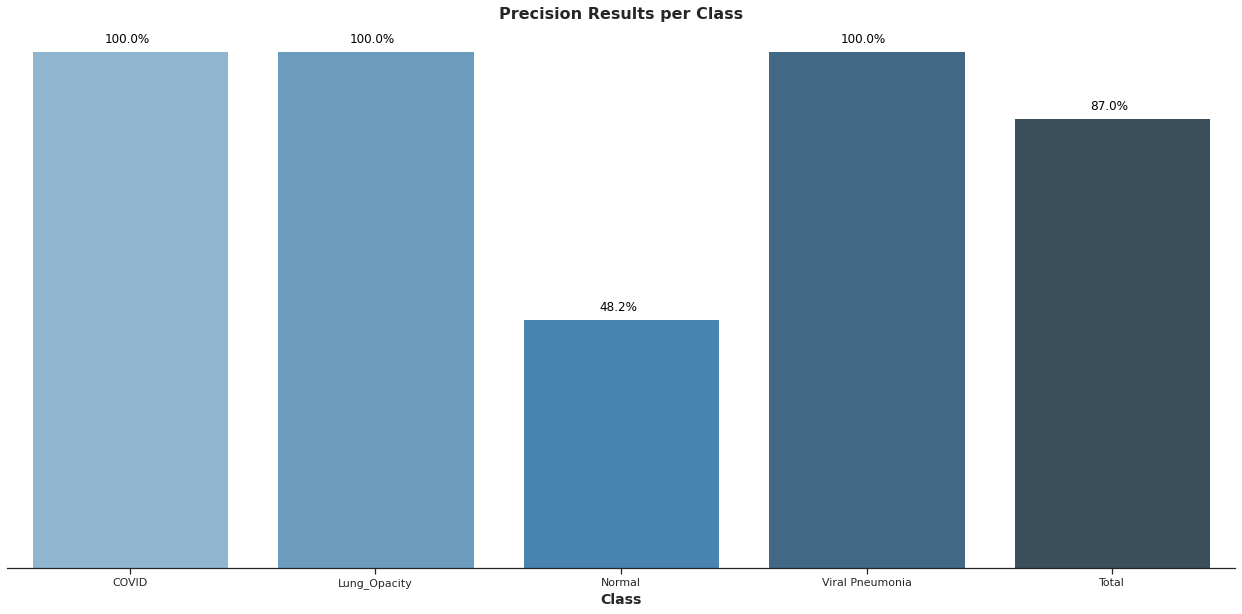

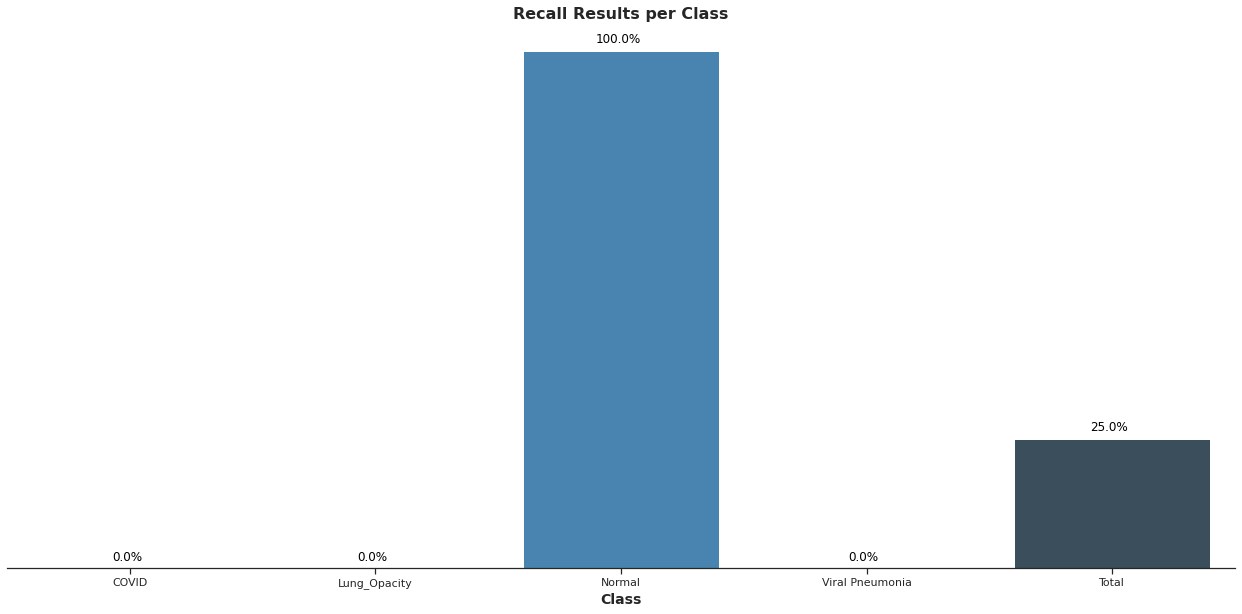

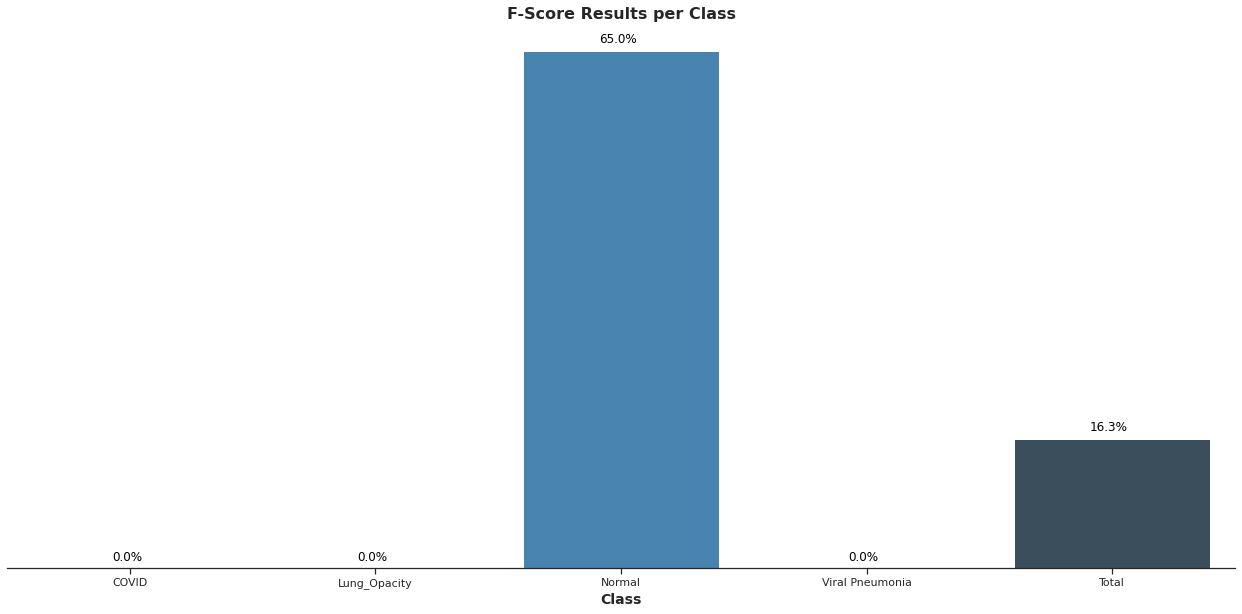

In [49]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[4,2]*100))#F-Score of the whole Dataset

In [50]:
pretrained_NasNet = tf.keras.applications.NASNetMobile(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in pretrained_NasNet.layers:
  layer.trainable = False

x4 = pretrained_NasNet.output
x4 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head_NasNet")(x4)
x4 = tf.keras.layers.Flatten(name="flatten_head_NasNet")(x4)
x4 = tf.keras.layers.Dense(256, activation="relu", name="dense_head_NasNet")(x4)
x4 = tf.keras.layers.Dropout(0.5, name="dropout_head_NasNet")(x4)
x4 = tf.keras.layers.Dense(128, activation="relu", name="dense_head_2_NasNet")(x4)
x4 = tf.keras.layers.Dropout(0.5, name="dropout_head_2_NasNet")(x4)
x4 = tf.keras.layers.Dense(64, activation="relu", name="dense_head_3_NasNet")(x4)
x4 = tf.keras.layers.Dropout(0.5, name="dropout_head_3_NasNet")(x4)
model_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions_head_NasNet")(x4)

model_NasNet = Model(inputs=pretrained_NasNet.input, outputs=model_out)
#model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=categorical_smooth_loss,metrics=['accuracy'])
#model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=[Recall()])
#Compile the model


opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model_NasNet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

20004864/19993432 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [51]:
#Model Parameters
epochs = 3 # make it 1000

#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100,monitor='val_loss', mode = 'min',verbose=0)

callbacks_list = [learning_rate_reduction,early_stopping_monitor]

#Verbose set to 0 to avoid Notebook visual pollution
history = model_NasNet.fit(train_gen, steps_per_epoch=len(train_gen) // batch_size, 
                                validation_steps=len(test_gen) // batch_size, 
                                validation_data=test_gen, epochs=epochs,callbacks=[callbacks_list],
                                verbose=1)
#Predict Results on test set
y_pred = model_NasNet.predict(test_gen)

Epoch 1/3
66/66 [==============================] - 112s 1s/step - loss: 5.6092 - accuracy: 0.3694 - val_loss: 1.7407 - val_accuracy: 0.0078
Epoch 2/3
66/66 [==============================] - 93s 1s/step - loss: 1.3675 - accuracy: 0.4167 - val_loss: 1.3188 - val_accuracy: 0.2422
Epoch 3/3
66/66 [==============================] - 95s 1s/step - loss: 1.1736 - accuracy: 0.4943 - val_loss: 1.3647 - val_accuracy: 0.1445


In [52]:
last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "averagepooling2d_head_NasNet",
    "flatten_head_NasNet",
    "dense_head_NasNet",
    "dropout_head_NasNet",
    "dense_head_2_NasNet",
    "dropout_head_2_NasNet",
    "dense_head_3_NasNet",
    "dropout_head_3_NasNet",
    "predictions_head_NasNet"
]

In [53]:
model_NasNet.save("model_NasNet_30_09596.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


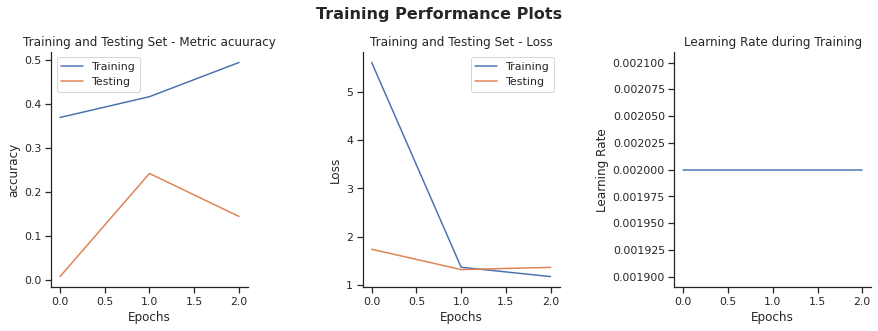

In [54]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(13,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="Testing");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="Testing");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Testing Set - Metric acuuracy")
axarr[1].set_title("Training and Testing Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

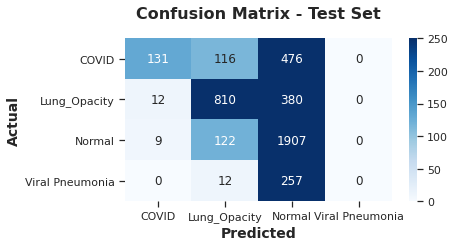

In [55]:
#transform the predictions into array such as [0,0,1,2...]
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
#Retrieve the True classes of the test set
y_true=test_gen.classes
#Build Confusion Matrix
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(6, 3))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

keras.backend.clear_session()

**Overall Results**
Accuracy Result: 67.30%
Precision Result: 81.44%
Recall Result: 44.77%
F-Score Result: 44.24%


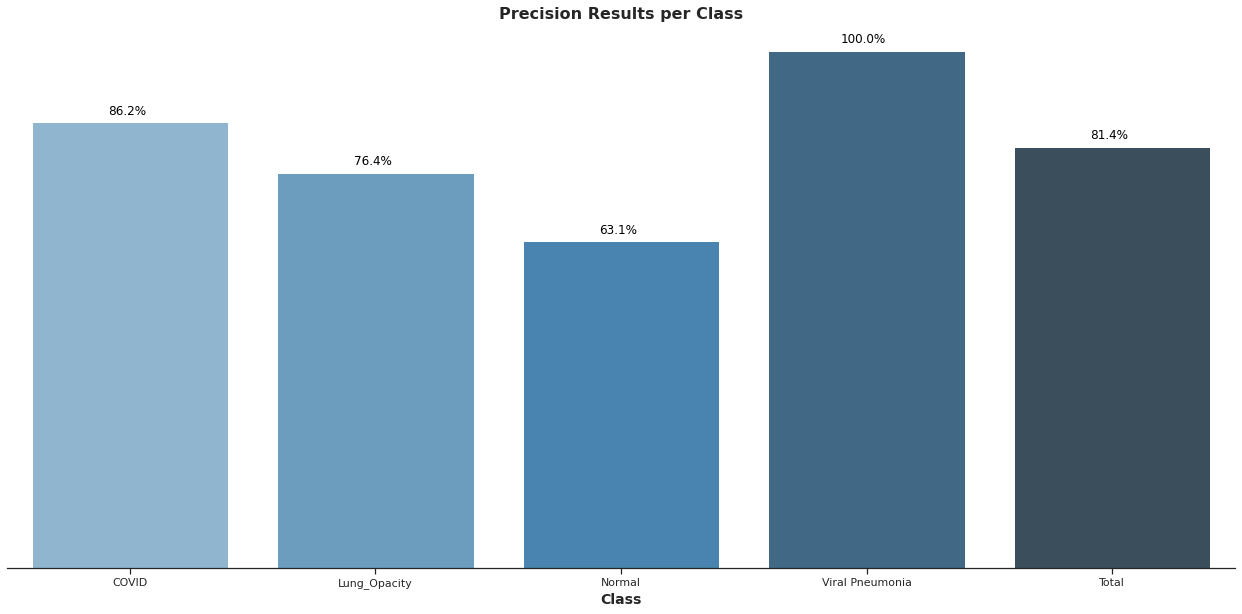

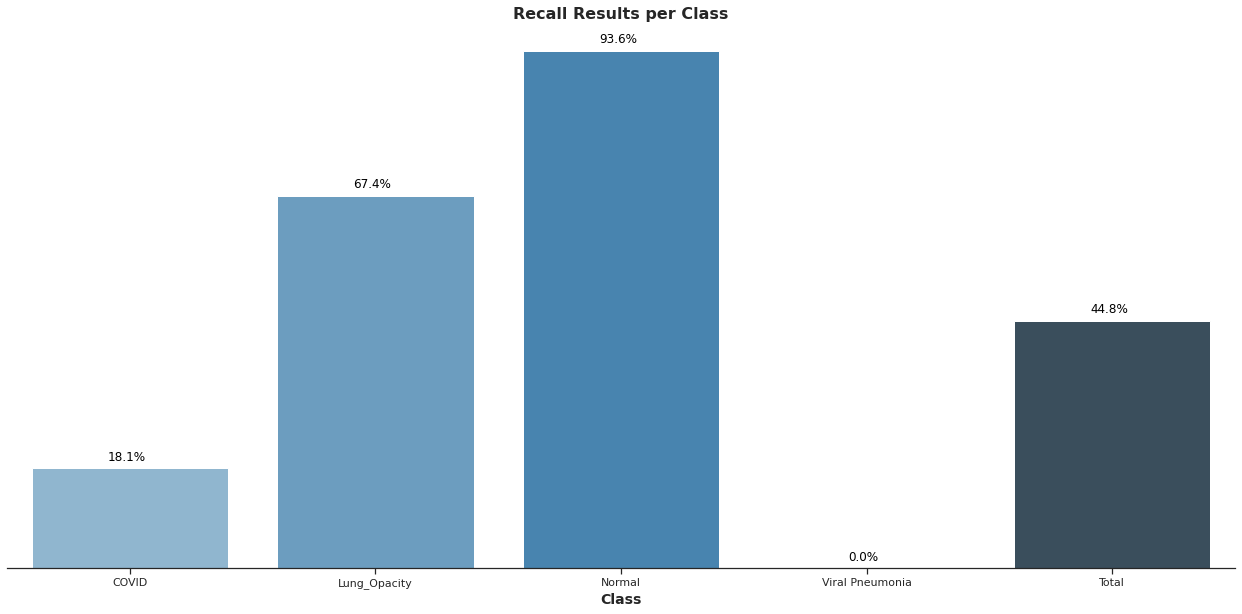

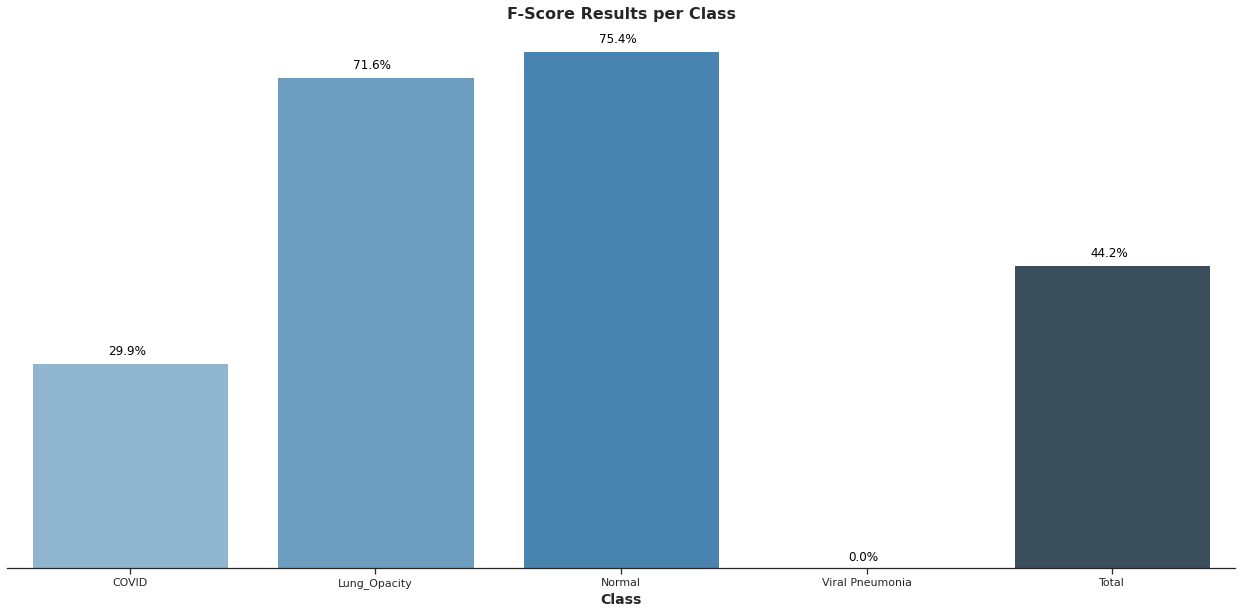

In [56]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[4,2]*100))#F-Score of the whole Dataset

## Ensemble (simply at the last layer)

In [71]:
# model_densenet
# model_efnet
# model_vgg

for layer in model_MobileNet.layers:
  layer.trainable = False

for layer in model_DenseNet.layers:
  layer.trainable = False

for layer in model_EfNet.layers:
  layer.trainable = False

for layer in model_NasNet.layers:
  layer.trainable = False

visible = tf.keras.layers.Input(shape=(224, 224, 3), name="input")
x = model_MobileNet(visible)
x = model_DenseNet(visible)
x = model_EfNet(visible)
x = model_NasNet(visible)
merge = tf.keras.layers.concatenate([x, x, x, x], name= "concatallprobs")
model_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions")(merge)

model_MobileNet_DenseNet_EfNet_NasNet = Model(inputs=visible, outputs=model_out)
model_MobileNet_DenseNet_EfNet_NasNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model_MobileNet_DenseNet_EfNet_NasNet.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 4)            6744408     input[0][0]                      
__________________________________________________________________________________________________
concatallprobs (Concatenate)    (None, 16)           0           model[10][0]                     
                                                                 model[10][0]                     
                                                                 model[10][0]                     
                                                                 model[10][0]              

In [73]:
#Model Parameters
epochs = 3 # make it 1000

#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100,monitor='val_loss', mode = 'min',verbose=0)

callbacks_list = [learning_rate_reduction,early_stopping_monitor]

#Verbose set to 0 to avoid Notebook visual pollution
history = model_MobileNet_DenseNet_EfNet_NasNet.fit(train_gen, steps_per_epoch=len(train_gen) // batch_size, 
                                validation_steps=len(test_gen) // batch_size, 
                                validation_data=test_gen, epochs=epochs,callbacks=[callbacks_list],
                                verbose=1)
#Predict Results on test set
y_pred = model_MobileNet_DenseNet_EfNet_NasNet.predict(test_gen)

Epoch 1/3
66/66 [==============================] - 119s 2s/step - loss: 1.3844 - accuracy: 0.2405 - val_loss: 1.2405 - val_accuracy: 0.0742
Epoch 2/3
66/66 [==============================] - 102s 2s/step - loss: 1.3523 - accuracy: 0.2727 - val_loss: 1.2582 - val_accuracy: 0.0625
Epoch 3/3
66/66 [==============================] - 100s 2s/step - loss: 1.3485 - accuracy: 0.2472 - val_loss: 1.2738 - val_accuracy: 0.0586


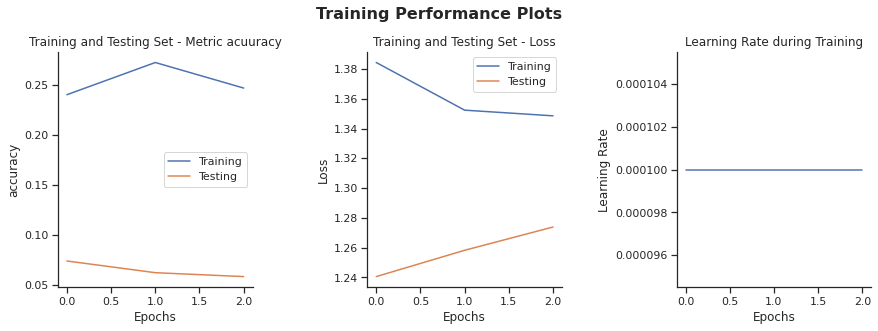

In [74]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(13,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="Testing");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="Testing");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Testing Set - Metric acuuracy")
axarr[1].set_title("Training and Testing Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

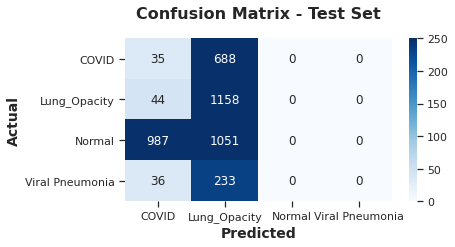

In [75]:
#transform the predictions into array such as [0,0,1,2...]
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
#Retrieve the True classes of the test set
y_true=test_gen.classes
#Build Confusion Matrix
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(6, 3))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

keras.backend.clear_session()

**Overall Results**
Accuracy Result: 28.19%
Precision Result: 60.04%
Recall Result: 25.30%
F-Score Result: 14.32%


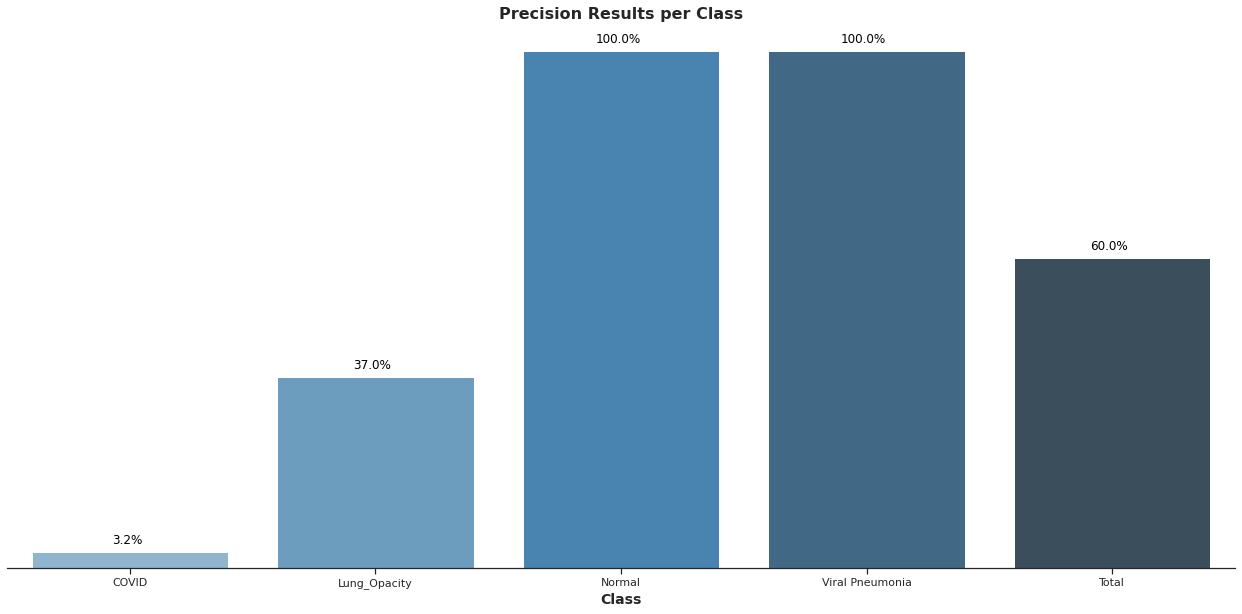

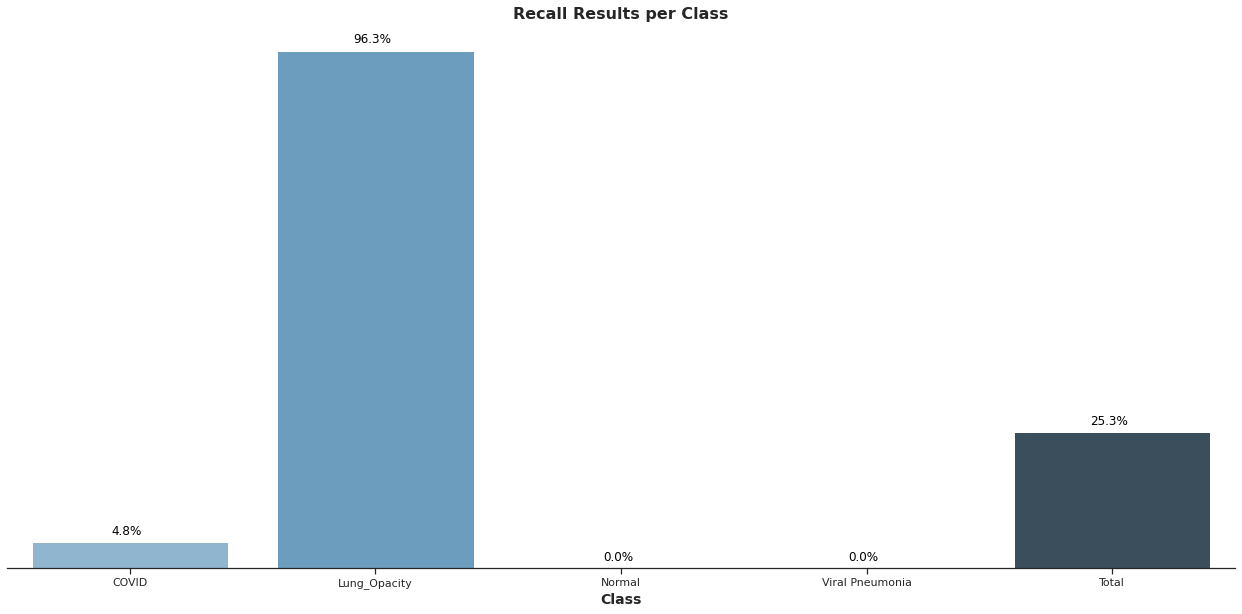

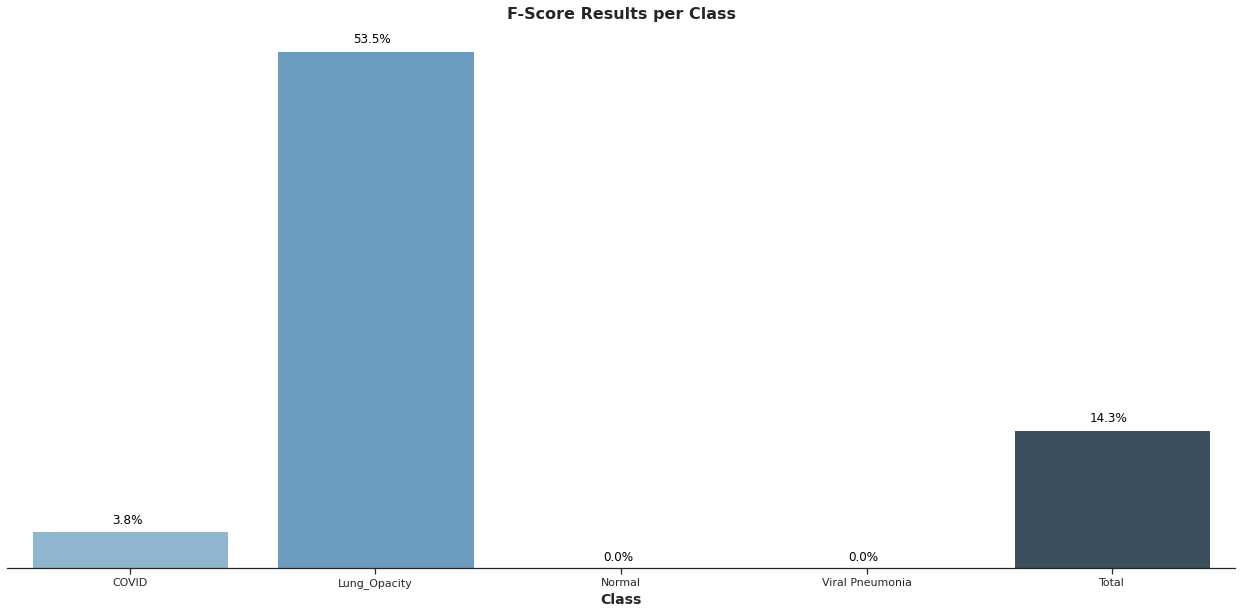

In [76]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[4,2]*100))#F-Score of the whole Dataset

In [77]:
model_MobileNet_DenseNet_EfNet_NasNet.save("model_MobileNet_DenseNet_EfNet_NasNet_09581.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Ensemble: without the heads

In [78]:
#Gives the network the chance to learn from the dense layers before the softmax

# model2= Model(inputs=model1.input, outputs=model1.get_layer(layer_name).output)

model_MobileNet_nohead = Model(inputs=model_MobileNet.input, outputs=model_MobileNet.get_layer("dense_head_2_MbNet").output)
model_DenseNet_nohead = Model(inputs=model_DenseNet.input, outputs=model_DenseNet.get_layer("dense_head_2_DenseNet").output)
model_EfNet_nohead = Model(inputs=model_EfNet.input, outputs=model_EfNet.get_layer("dense_head_2_EfNet").output)
model_NasNet_nohead = Model(inputs=model_NasNet.input, outputs=model_NasNet.get_layer("dense_head_3_NasNet").output)

for layer in model_MobileNet_nohead.layers:
  layer.trainable = False

for layer in model_DenseNet_nohead.layers:
  layer.trainable = False

for layer in model_EfNet_nohead.layers:
  layer.trainable = False

for layer in model_NasNet_nohead.layers:
  layer.trainable = False

visible = tf.keras.layers.Input(shape=(224, 224, 3), name="input")
x = model_MobileNet_nohead(visible)
x = model_DenseNet_nohead(visible)
x = model_EfNet_nohead(visible)
x = model_NasNet_nohead(visible)

merge = tf.keras.layers.concatenate([x, x, x, x], name="concatallprobs")
model_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions")(merge)

model_MobileNet_DenseNet_EfNet_NasNet_nohead = Model(inputs=visible, outputs=model_out)
model_MobileNet_DenseNet_EfNet_NasNet_nohead.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy']) #categorical_smooth_loss
model_MobileNet_DenseNet_EfNet_NasNet_nohead.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_3 (Functional)            (None, 64)           6744148     input[0][0]                      
__________________________________________________________________________________________________
concatallprobs (Concatenate)    (None, 256)          0           model_3[0][0]                    
                                                                 model_3[0][0]                    
                                                                 model_3[0][0]                    
                                                                 model_3[0][0]              

In [79]:
#Model Parameters
epochs = 3 # make it 1000

#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100,monitor='val_loss', mode = 'min',verbose=0)

callbacks_list = [learning_rate_reduction,early_stopping_monitor]

#Verbose set to 0 to avoid Notebook visual pollution
history = model_MobileNet_DenseNet_EfNet_NasNet_nohead.fit(train_gen, steps_per_epoch=len(train_gen) // batch_size, 
                                validation_steps=len(test_gen) // batch_size, 
                                validation_data=test_gen, epochs=epochs,callbacks=[callbacks_list],
                                verbose=1)
#Predict Results on test set
y_pred = model_MobileNet_DenseNet_EfNet_NasNet_nohead.predict(test_gen)

Epoch 1/3
66/66 [==============================] - 120s 2s/step - loss: 1.1901 - accuracy: 0.4858 - val_loss: 1.5047 - val_accuracy: 0.0000e+00
Epoch 2/3
66/66 [==============================] - 94s 1s/step - loss: 1.0555 - accuracy: 0.5587 - val_loss: 1.3471 - val_accuracy: 0.1367
Epoch 3/3
66/66 [==============================] - 96s 1s/step - loss: 1.0185 - accuracy: 0.5701 - val_loss: 1.3926 - val_accuracy: 0.1328


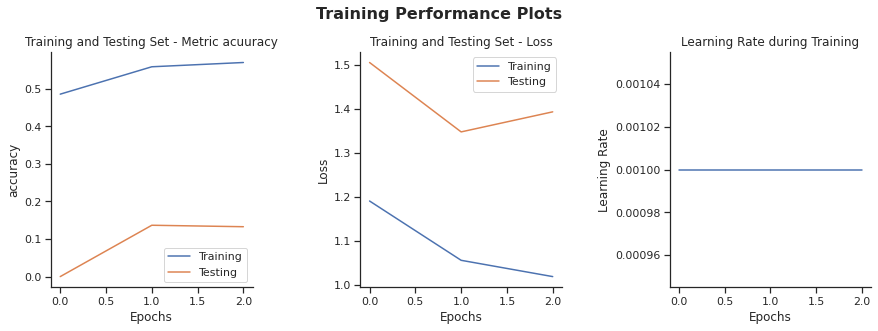

In [80]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(13,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="Testing");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="Testing");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Testing Set - Metric acuuracy")
axarr[1].set_title("Training and Testing Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

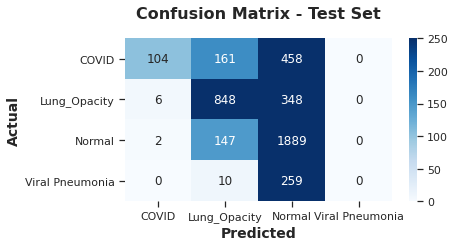

In [81]:
#transform the predictions into array such as [0,0,1,2...]
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
#Retrieve the True classes of the test set
y_true=test_gen.classes
#Build Confusion Matrix
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(6, 3))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

keras.backend.clear_session()

**Overall Results**
Accuracy Result: 67.13%
Precision Result: 82.38%
Recall Result: 44.41%
F-Score Result: 43.05%


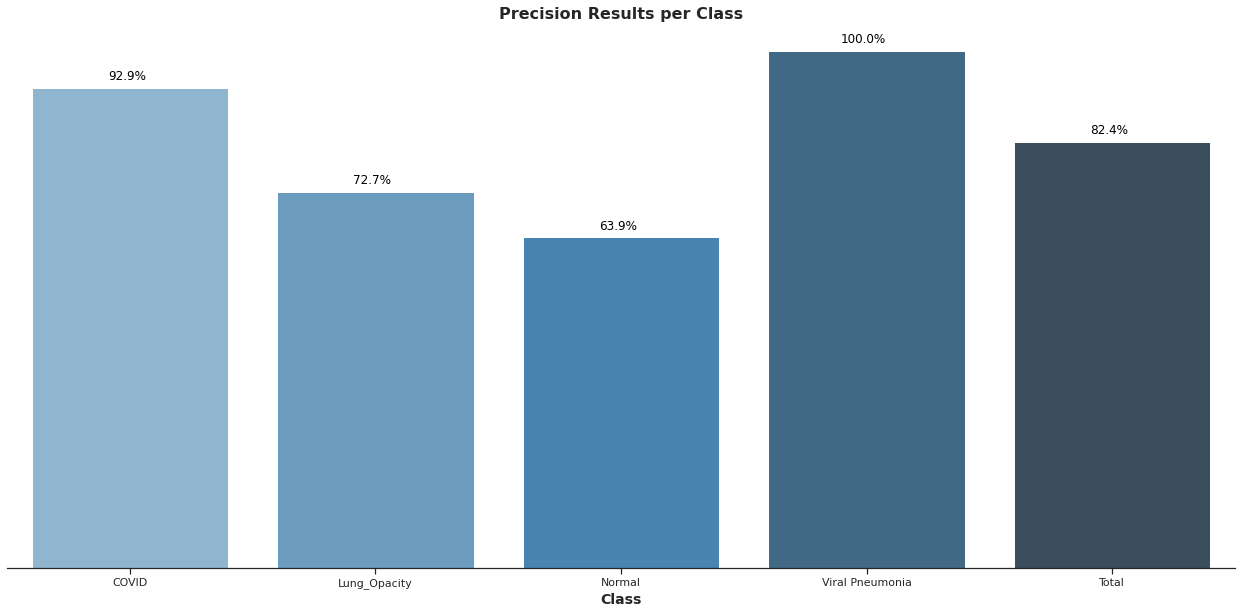

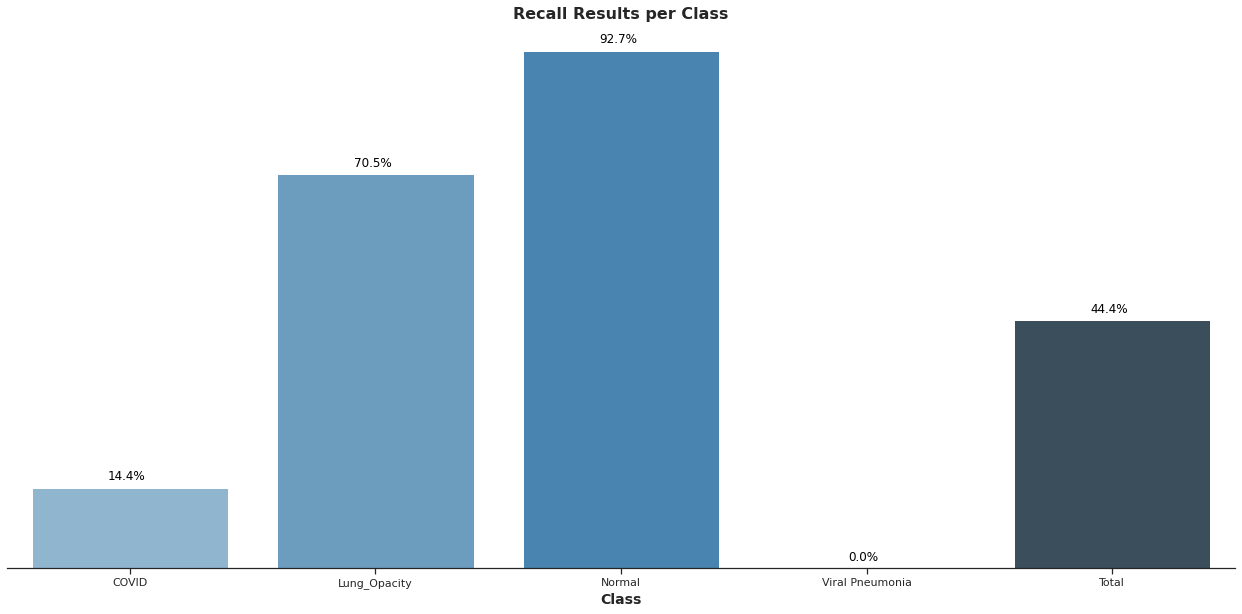

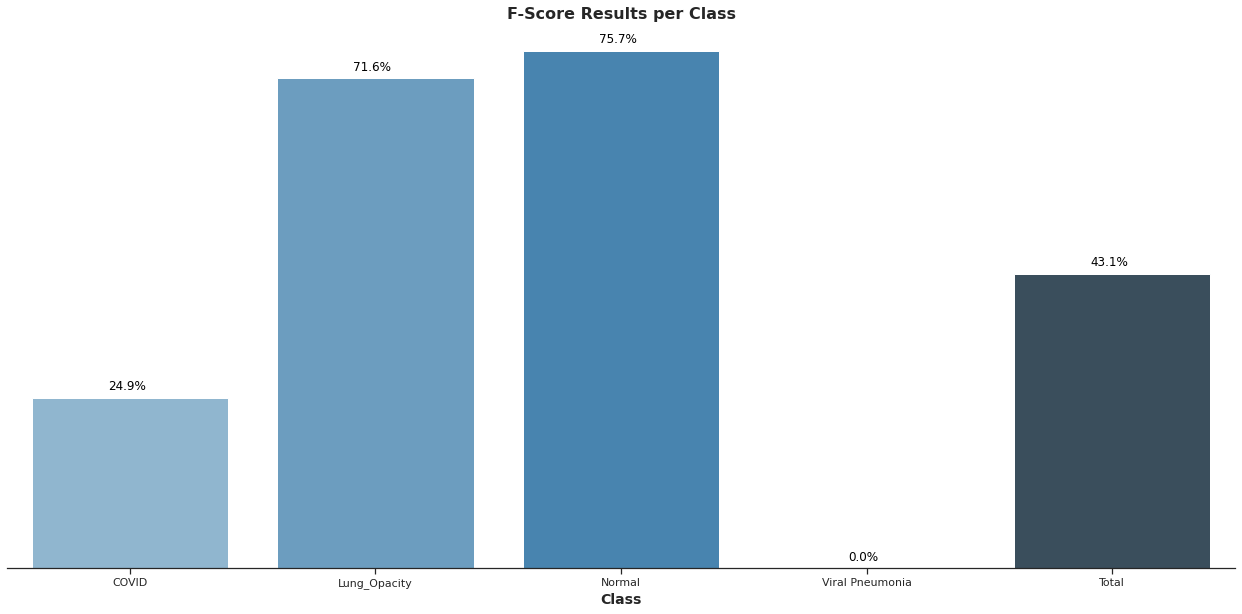

In [82]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[4,2]*100))#F-Score of the whole Dataset

In [83]:
model_MobileNet_DenseNet_EfNet_NasNet_nohead.save("model_MobileNet_DenseNet_EfNet_NasNet_nohead_09xxx.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [85]:
 # paizullah begherata, dala, daosss, koni, pareeha malgari, khargosh ghole,